# Density estimation with multimodal reverse KL minimization
In my previous [post](https://www.kaggle.com/code/runway/reverse-kl-minimization), I discussed density estimation by reverse KL minimization. Very briefly, we want to minimize the KL divergence between a distribution $Q(x)$ and a target distribution $P(x)$ given only samples from $P(x)$. Formally, our objective is
\begin{align}
\begin{split}
\min_{Q(x)} &\quad \mathcal{D}_{KL}(Q(x) || P(x)) \\
&= \mathbb{E}_{Q(x)}[\log\frac{Q(x)}{P(x)}] \\
&= \mathbb{E}_{Q(x)}[\log r(x)] \\
\end{split}
\end{align}
Where $r(x)$ is the estimated density ratio. The optimization proceeds by drawing samples from $Q(x)$ and evaluate the objective above using the reparameterization trick (e.g., this [blog](https://gregorygundersen.com/blog/2018/04/29/reparameterization/)). 

This procedure resembles Generative Adversarial Networks (GANs), and it also suffers GAN's problem: mode seeking, which means if your data distribution is multimodal, $Q(x)$ will tend to only match one of the modes. 

One way to overcome mode seeking is to parameterize $Q(x)$ with a multimodal distribution. A common choice is a discrete mixture distribution, such as mixture of gaussians. Let $\{Q_1(x), ..., Q_K(x)\}$ be $K$ gaussians and $\Pi = \{\pi_1, ..., \pi_K\}$ be the weights, the gaussian mixture density has a closed form expression:
\begin{align}
Q(x) = \sum_{k=1}^K \pi_k Q_k(x)
\end{align}
Sampling from the gaussian mixture requires first sampling a discrete component and then sample from the selected gaussian. Unfortunately, sampling from a discrete distribution cannot be done easily with the basic reparameterization trick. 

In this post, we will explore three ways to overcome the difficulty of sampling from the gaussian mixture distribution:
1. Stratified sampling: [Automatic differentiation variational inference with mixtures, Morningstar et al, 2020](https://arxiv.org/abs/2003.01687)
2. Gumbel-softmax sampling: [Categorical reparameterization with gumbel-softmax, Jang et al, 2016](https://arxiv.org/abs/1611.01144)
3. Expected information maximization: [Expected information maximization: using the I-projection for mixture density estimation, Becker et al, 2020](https://arxiv.org/abs/2001.08682)

Specifically, we are looking for how close are the fitted densities to the data density and the learning speed of the three methods.

Let's get started!

In [1]:
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as torch_dist

seed = 0

font_size = 14
strip_size = 12

plt.rc('font', size=font_size)           
plt.rc('axes', titlesize=font_size)      
plt.rc('axes', labelsize=strip_size)     
plt.rc('xtick', labelsize=strip_size)    
plt.rc('ytick', labelsize=strip_size)    
plt.rc('legend', fontsize=strip_size)    

## Create GMM class
We will first create a gaussian mixture class to define our data and sampling distributions. We will implement a method to sample from each mixture component and a method to perform the top down ancestral sampling.

In [2]:
class GMM(nn.Module):
    """ 1D GMM """ 
    def __init__(self, mu, lv, pi):
        """
        Args
            mu (torch.tensor): component means. size=[num_components]
            lv (torch.tensor): component log variances. size=[num_components]
            pi (torch.tensor): mixing weights. size=[num_components]
        """
        super().__init__()
        self.mu = nn.Parameter(mu)
        self.lv = nn.Parameter(lv)
        self.pi = nn.Parameter(pi)
    
    def component_distributions(self):
        return torch_dist.Normal(self.mu, self.lv.exp())

    def pdf(self, x):
        """ Mixture density """
        pdf_c = self.component_distributions().log_prob(x).exp()
        pi = torch.softmax(self.pi, dim=-1).view(1, -1)
        return torch.sum(pi * pdf_c, dim=-1)

    def log_prob(self, x):
        return self.pdf.log()
    
    def sample_component(self, num_samples):
        """ Draw num_samples of samples from each component """
        samples = self.component_distributions().rsample((num_samples,))
        return samples

    def sample(self, num_samples, tau=0.5, hard=True):
        """ Differentiable ancestral sampling with gumbel-softmax
        
        Args:
            num_samples (int): number of samples to draw
            tau (float): gumbel-softmax temperature
            hard (bool): if hard use one-hot samples. Otherwise use soft categorical samples.
        """
        logp_pi = self.pi.view(1, -1).repeat_interleave(num_samples, 0)
        z_ = F.gumbel_softmax(logp_pi, tau=tau, hard=hard)
        x_ = self.sample_component(num_samples)
        x = torch.sum(x_ * z_, dim=-1)
        return x

Below we will create a real dataset sampled from a GMM with fixed parameters and an arbitrary fake dataset.

In [3]:
# generate dataset
torch.manual_seed(seed)
num_samples = 3000

# create real GMM
real_mu = torch.tensor([-3., 1.])
real_lv = torch.tensor([1., 0.5]).log()
real_pi = torch.tensor([0.4, 0.6]).exp()

real_gmm = GMM(real_mu, real_lv, real_pi)
real_samples = real_gmm.sample(num_samples).data

# create fake GMM
fake_mu = 2 * torch.randn(2)
fake_lv = 0.1 * torch.randn(2)
fake_pi = 0.1 * torch.randn(2)

fake_gmm = GMM(fake_mu, fake_lv, fake_pi)
fake_samples = fake_gmm.sample(num_samples).data

## Density ratio estimation with neural network classifier
As a sanity check, we will first do a density ratio estimation. Different from the [last post](https://www.kaggle.com/code/runway/reverse-kl-minimization), where both distributions are gaussian, the density ratio is no longer quadratic. We will estimate the density ratio with a neural network classifier.

In [4]:
class Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_hidden, activation="silu"):
        super().__init__()
        
        layers = []
        last_dim = input_dim
        for i in range(num_hidden + 1):
            layers.append(nn.Linear(last_dim, hidden_dim))
            if activation == "silu":
                layers.append(nn.SiLU())
            elif activation == "sigmoid":
                layers.append(nn.Sigmoid())
            elif activation == "relu":
                layers.append(nn.ReLU())
            last_dim = hidden_dim
        self.layers = nn.ModuleList(layers)

        self.head = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
            
        out = self.head(x)
        return out

We will define the following classifier training loop. We will make use of this loop to train the classifier in later sections.

In [5]:
def train_classifier(clf, optimizer, real_samples, fake_sample, epochs, verbose=None):
    clf_inputs = torch.cat([real_samples, fake_samples], dim=0).view(-1, 1)
    labels = torch.cat([torch.zeros(num_samples, 1), torch.ones(num_samples, 1)], dim=0)

    history = []
    for e in range(epochs):
        pred = torch.sigmoid(clf(clf_inputs))
        loss = F.binary_cross_entropy(pred, labels)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        history.append(loss.data.item())

        if verbose is not None and (e + 1) % verbose == 0:
            print(f"{e + 1}, loss: {loss.data.item():.6f}")
    return clf, history

In [6]:
# density ratio estimation of GMM
torch.manual_seed(seed)

hidden_dim = 32
num_hidden = 2
lr = 0.005
epochs = 200

clf = Classifier(1, hidden_dim, num_hidden, "silu")
optimizer = torch.optim.Adam(clf.parameters(), lr=lr)

clf, history = train_classifier(
    clf, optimizer, real_samples, fake_samples, epochs, verbose=20
)

20, loss: 0.604746
40, loss: 0.518209
60, loss: 0.494688
80, loss: 0.491427
100, loss: 0.490971
120, loss: 0.490922
140, loss: 0.490909
160, loss: 0.491709
180, loss: 0.490935
200, loss: 0.490896


We will use the function below to plot all our learning curves in this post.

In [7]:
def plot_history(history):
    loss_keys = list(history.keys())
    num_cols = len(loss_keys)

    fig, ax = plt.subplots(1, num_cols, figsize=(4*num_cols, 4))
    if num_cols == 1:
        ax = [ax]

    for i in range(num_cols):
        ax[i].plot(history[loss_keys[i]])
        ax[i].set_xlabel("epoch")
        ax[i].set_ylabel(loss_keys[i])

    plt.tight_layout()
    return fig, ax

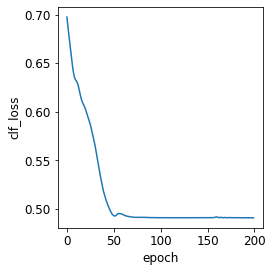

In [8]:
fig, ax = plot_history({"clf_loss": history})
plt.show()

We will use the function below to visualize the learned models. fake_gmm is the sampling distribution, which is fixed in the case above and will be trained to match the real_gmm in later sections. Specifically we will do two things:
1. Reconstruct the fake gmm density from the density ratio estimated by the classifier using formula $\hat{Q}(x) = \hat{r}(x)P(x)$ and compare with the true fake density
2. Plot the estimated density ratio and log density ratio

In [9]:
def plot_diagnostics(real_gmm, fake_gmm, clf, xlim=[-10, 5]):
    grid = torch.linspace(xlim[0], xlim[1], 500).view(-1, 1)

    p_real = real_gmm.pdf(grid).data
    p_fake = fake_gmm.pdf(grid).data
    r = p_fake / p_real

    # predict density ratio
    with torch.no_grad():
        log_r_pred = clf(grid).data.view(-1)
        r_pred = log_r_pred.exp()
        p_fake_pred = r_pred * p_real

    fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharex=True)
    ax[0].plot(grid, p_real, label="real")
    ax[0].plot(grid, p_fake, label="fake")
    ax[0].plot(grid, p_fake_pred, "--", label="fake_pred")

    ax[1].plot(grid, r, label="r")
    ax[1].plot(grid, r_pred, "--", label="r_pred")

    ax[2].plot(grid, torch.log(r), label="log_r")
    ax[2].plot(grid, log_r_pred, "--", label="log_r_pred")

    ax[0].legend()
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("pdf")

    ax[1].legend()
    ax[1].set_xlabel("x")
    ax[1].set_ylabel("fake/real")

    ax[2].legend()
    ax[2].set_xlabel("x")
    ax[2].set_ylabel("log(fake/real)")

    plt.tight_layout()
    return fig, ax

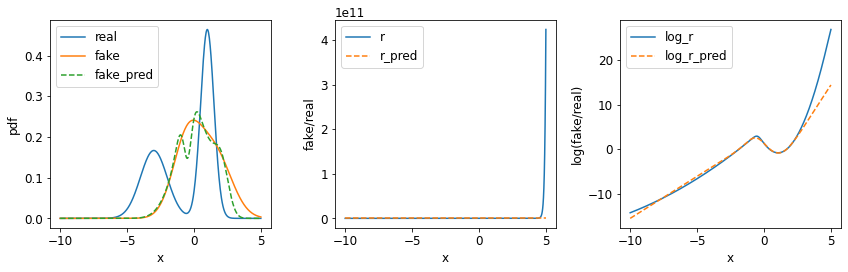

In [10]:
fig, ax = plot_diagnostics(real_gmm, fake_gmm, clf)
plt.show()

Notes:
* We see that the fake distribution reconstructed form the estimated density ratio (fake_pred) roughly follow the contour of the actual fake density.

### Method 1. Reverse KL minimization with stratified sampling
After verifying that density ratio between two gmms can be estimated, we are now ready to perform the KL minimization.

The first method we will implement is stratified sampling discussed in [this paper](https://arxiv.org/abs/2003.01687) and [this paper](https://arxiv.org/abs/1703.09194), where the authors are interested in training multimodal posteriors in the context of Variational Autoencoders. We now see how this can be applied to GAN like training here. 

The observation is that our objective can be written as:
\begin{align}
&\min_{Q(x)}\mathbb{E}_{Q(x)}[\log r(x)] = \sum_{k=1}^K \pi_k \int_x Q_k(x) \log r(x)
\end{align}
We can thus evaluate the integral using a single sample from each component via the reparameterization trick:
\begin{align}
\sum_{k=1}^K \pi_k \mathbb{E}_{x \sim Q(x)}[\log r(x)]
\end{align}
The reason why this method is called stratified sampling is that we first sample from each "component strata" and than perform a weighted average. It also means that we have to evaluate the density ratio (by passing through a neural network) $K$ times for each data sample. 

From now on we will call the loss function used to train the sampling/proposal distribution $Q(x)$ "q_loss" as opposed to the binary cross entropy loss function used to train the classifier. 

Note that similar to the [last post](https://www.kaggle.com/code/runway/reverse-kl-minimization), we may also add a KL divergence penalty to q_loss prevent the udpated gmm $Q(x)$ to be too different from the previous gmm $Q'(x)$. We will implement it as the sum of the KL divergences of the mixing distributions and component distributions:
\begin{align}
\mathcal{D}_{KL}(Q(x) || Q'(x)) = \mathcal{D}_{KL}(\pi || \pi') + \sum_{k=1}^K \mathcal{D}_{KL}(Q_{k}(x) || Q_{k}'(x))
\end{align}

We implement this loss function below, which applies equally to all three methods considered.

In [11]:
def gmm_kl_divergence(gmm1, gmm2):
    """ Compute the latent and component kl divergence between two gmm objects """
    pi1 = torch.softmax(gmm1.pi, dim=-1)
    pi2 = torch.softmax(gmm2.pi.data, dim=-1)
    kl_z = torch_dist.kl.kl_divergence(
        torch.distributions.Categorical(pi1),
        torch.distributions.Categorical(pi2)
    )

    q1 = torch.distributions.Normal(gmm1.mu, gmm1.lv.exp())
    q2 = torch.distributions.Normal(gmm2.mu, gmm2.lv.exp())
    kl_x = torch.distributions.kl.kl_divergence(q1, q2).sum()
    return kl_z, kl_x

We use the function below to compute the stratified q_loss -- the loss function for the proposal distribution.

In [12]:
def compute_stratified_q_loss(gmm, clf, num_samples, old_gmm, kl_penalty):
    fake_samples = gmm.sample_component(num_samples).unsqueeze(-1)
    log_r_x = clf(fake_samples).squeeze(-1) # compute log density ratio using the trained classifier
    log_r_z = log_r_x.mean(0) # average over num_samles

    pi = torch.softmax(gmm.pi, dim=-1)
    loss = torch.sum(pi * log_r_z) # average over strata
    
    kl_z, kl_x = gmm_kl_divergence(gmm, old_gmm)
    return loss + kl_penalty * (kl_z + kl_x)

We will use the same seed, classifier size, learning rates and training epochs for all methods below.

In [13]:
# stratified sampling algorithm
torch.manual_seed(seed)

hidden_dim = 32
num_hidden = 2
lr_clf = 0.005
lr_q = 0.01
decay=0
epochs = 100
e_step = 30 # estimate dr
m_step = 10 # minimize kl
kl_penalty = 1

q_mu = torch.randn(2)
q_lv = 0.1 * torch.randn(2)
q_pi = 0.1 * torch.randn(2)
q_gmm = GMM(q_mu, q_lv, q_pi)
clf = Classifier(1, hidden_dim, num_hidden, "silu")

clf_optimizer = torch.optim.Adam(clf.parameters(), lr=lr_clf, weight_decay=decay)
q_optimizer = torch.optim.Adam(q_gmm.parameters(), lr=lr_q, weight_decay=decay)

history = {"clf_loss": [], "q_loss": []}
for e in range(epochs):
    # store last proposal 
    q_gmm_last = deepcopy(q_gmm)
    for p in q_gmm_last.parameters():
        p.requires_grad = False

    # generate fake samples
    with torch.no_grad():
        fake_samples = q_gmm.sample(num_samples).data
    
    clf, clf_history = train_classifier(
        clf, clf_optimizer, real_samples, fake_samples, e_step
    )
    history["clf_loss"].append(clf_history[-1])

    # train proposal distribution 
    for i in range(m_step):
        q_loss = compute_stratified_q_loss(
            q_gmm, clf, num_samples, q_gmm_last, kl_penalty
        )
        
        q_loss.backward()
        q_optimizer.step()
        q_optimizer.zero_grad()
        clf_optimizer.zero_grad()

    history["q_loss"].append(q_loss.data.item())

    if (e + 1) % 10 == 0:
        print("{}, clf_loss: {:.4f}, q_loss: {:.4f}".format(
            e + 1, history["clf_loss"][-1], history["q_loss"][-1]
        ))

stratified_history = deepcopy(history)

10, clf_loss: 0.6460, q_loss: 0.1822
20, clf_loss: 0.6678, q_loss: 0.0893
30, clf_loss: 0.6873, q_loss: 0.0145
40, clf_loss: 0.6929, q_loss: -0.0009
50, clf_loss: 0.6927, q_loss: 0.0095
60, clf_loss: 0.6927, q_loss: 0.0022
70, clf_loss: 0.6925, q_loss: -0.0041
80, clf_loss: 0.6922, q_loss: -0.0013
90, clf_loss: 0.6926, q_loss: 0.0007
100, clf_loss: 0.6926, q_loss: -0.0037


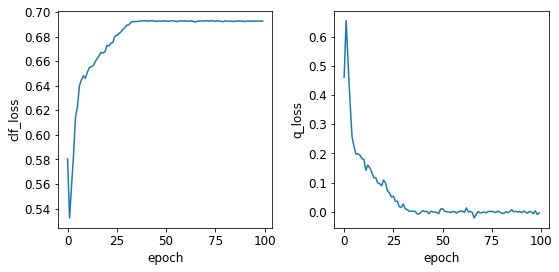

In [14]:
fig, ax = plot_history(stratified_history)
plt.show()

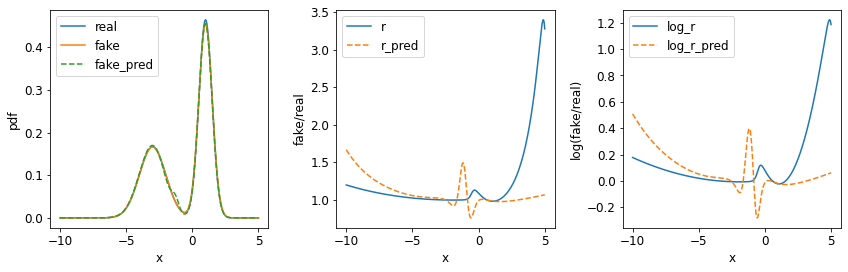

In [15]:
fig, ax = plot_diagnostics(real_gmm, q_gmm, clf)
plt.show()

Notes: 
* As expected, we have trained a gaussian mixture which closely match the real data distribution (observe the blue and orange curves in the left figure). Importantly, we achieved this by minimizing the reverse KL divergence rather than the forward KL divergence as in the popular Expectation Maximization method. 
* The optimization method is also very smooth and converged nicely. 

### Method 2. Reverse KL minimization with Gumbel-softmax sampling

The next method we will implement is the [gumbel-softmax trick](https://arxiv.org/abs/1611.01144), a discrete version of the reparameterization trick. Understanding the gumbel-softmax trick involves a littile bit of math, so I will refer you to the [inventor's post](https://blog.evjang.com/2016/11/tutorial-categorical-variational.html) and this [awesome post](https://casmls.github.io/general/2017/02/01/GumbelSoftmax.html). The basic idea this that we can draw a single sample from the mixing distribution $k \sim \pi$ and then a single sample from the selected component distribution $x \sim Q_{k}(x)$ without breaking the gradient flow. Specifically, sampling is done in sequentially:
\begin{align}
\mathbb{E}_{k \sim \Pi, x \sim Q_{k}(x)}[\log r(x)]
\end{align}

In practice, this is evaluated by sampling a "soft" one-hot index $\pi_{soft} = \{\pi_{soft}^{1}, ..., \pi_{soft}^{K}\}$ which sums to one. An approximate sample is computed as 
\begin{align}
x_{soft} = \sum_{k=1}^{K} \pi_{soft}^{k}x_{k}, \quad x_{k} \sim Q_{k}(x)
\end{align}
Then $x_{soft}$ is passed through the classifier to get: $\log r(x_{soft})$. The benefit is that we only need to evaluate the density ratio for a single sample rather than $K$ samples as in the previous method.

I have implemented the gumbel-softmax sampling in the gmm class using [pytoch's implementation](https://pytorch.org/docs/stable/generated/torch.nn.functional.gumbel_softmax.html). 

In [16]:
def compute_gumbel_q_loss(gmm, clf, num_samples, old_gmm, kl_penalty, tau, hard):
    fake_samples = gmm.sample(num_samples, tau=tau, hard=hard).unsqueeze(-1)
    log_r_x = clf(fake_samples).squeeze(-1)

    loss = log_r_x.mean()
    kl_z, kl_x = gmm_kl_divergence(gmm, old_gmm)
    return loss + kl_penalty * (kl_z + kl_x)

In [17]:
# gumbel-softmax sampling algorithm
torch.manual_seed(seed)

hidden_dim = 32
num_hidden = 2
lr_clf = 0.005
lr_q = 0.01
decay=0
epochs = 100
e_step = 30 # estimate dr
m_step = 10 # minimize kl
kl_penalty = 1
tau = 0.1 # softmax temperature
hard = False # hard sample

q_mu = torch.randn(2)
q_lv = 0.1 * torch.randn(2)
q_pi = 0.1 * torch.randn(2)
q_gmm = GMM(q_mu, q_lv, q_pi)
clf = Classifier(1, hidden_dim, num_hidden, "silu")

clf_optimizer = torch.optim.Adam(clf.parameters(), lr=lr_clf, weight_decay=decay)
q_optimizer = torch.optim.Adam(q_gmm.parameters(), lr=lr_q, weight_decay=decay)

history = {"clf_loss": [], "q_loss": []}
for e in range(epochs):
    # store last proposal 
    q_gmm_last = deepcopy(q_gmm)
    for p in q_gmm_last.parameters():
        p.requires_grad = False

    # generate fake samples
    with torch.no_grad():
        fake_samples = q_gmm.sample(num_samples).data
    
    clf, clf_history = train_classifier(
        clf, clf_optimizer, real_samples, fake_samples, e_step
    )
    history["clf_loss"].append(clf_history[-1])

    # train proposal distribution 
    for i in range(m_step):
        q_loss = compute_gumbel_q_loss(
            q_gmm, clf, num_samples, q_gmm_last, kl_penalty, tau, hard
        )
        
        q_loss.backward()

        q_optimizer.step()
        q_optimizer.zero_grad()
        clf_optimizer.zero_grad()

    history["q_loss"].append(q_loss.data.item())

    if (e + 1) % 10 == 0:
        print("{}, clf_loss: {:.4f}, q_loss: {:.4f}".format(
            e + 1, history["clf_loss"][-1], history["q_loss"][-1]
        ))

gumbel_history = deepcopy(history)

10, clf_loss: 0.6483, q_loss: 0.1998
20, clf_loss: 0.6697, q_loss: 0.1323
30, clf_loss: 0.6841, q_loss: 0.0614
40, clf_loss: 0.6922, q_loss: 0.0048
50, clf_loss: 0.6920, q_loss: 0.0144
60, clf_loss: 0.6929, q_loss: -0.0032
70, clf_loss: 0.6927, q_loss: 0.0007
80, clf_loss: 0.6925, q_loss: 0.0089
90, clf_loss: 0.6928, q_loss: -0.0088
100, clf_loss: 0.6925, q_loss: -0.0075


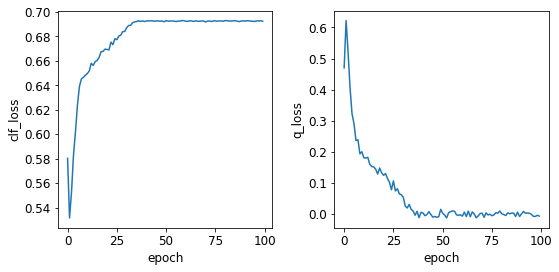

In [18]:
fig, ax = plot_history(gumbel_history)
plt.show()

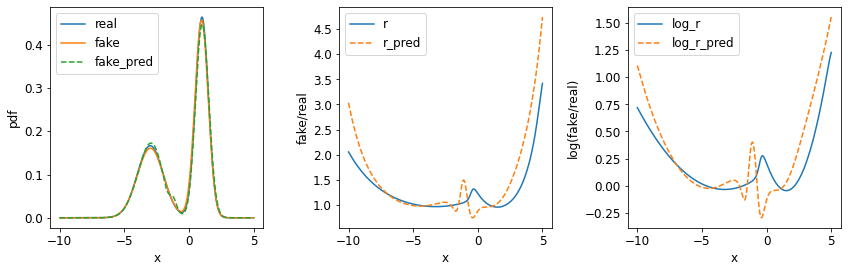

In [19]:
fig, ax = plot_diagnostics(real_gmm, q_gmm, clf)
plt.show()

Notes:
* We see that the fitted gmm also passes the visual test as being close enough to the real one. However, the density ratio is further away from 1 as we move away from the data-dense region. 

### Method 3. Expected information maximization

The last method we will implement is [expected information maximization (EIM)](https://arxiv.org/abs/2001.08682). It was proposed to exactly perform the task in this post: fit mixture density using reverse KL minimization. 

The authors derived a novel upper bound on the reverse KL referred to as the reverse ELBO in [this post](http://boris-belousov.net/2019/07/24/reverse-elbo/):
\begin{align}
\sum_{k}\pi_{k}\int_{x}Q_{k}(x)\log\frac{Q'(x)}{P(x)} + \sum_{k}\pi_{k}\mathcal{D}_{KL}(Q(x|z) || Q'(x|z)) + \mathcal{D}_{KL}(\Pi || \Pi')
\end{align}

Where $Q'(x) = \sum_{k}\pi_{k}'Q_{k}(x)$ is the gmm from the previous iteration. 

Thus, in each $Q(x)$ training iteration, EIM alternates between updating $\Pi$ using:
\begin{align}
\min_{\Pi} \sum_{k}\pi_{k}\int_{x}Q_{k}(x)\log\frac{Q'(x)}{P(x)} + \mathcal{D}_{KL}(\Pi || \Pi')
\end{align}
while fixing $Q_{k}(x)$. The integral inside the first term acts as the log density ratio for the mixing weights. We will call this loss function "z_loss". 

And updating $Q_{k}(x)$ using:
\begin{align}
\min_{Q_{k}(x)} \sum_{k}\pi_{k}\int_{x}Q_{k}(x)\log\frac{Q'(x)}{P(x)} + \sum_{k}\pi_{k}\mathcal{D}_{KL}(Q(x|z) || Q'(x|z))
\end{align}
while fixing $\Pi$. Notice that the first term in the above equation is exactly equal to the stratified sampling objective. We will call this loss function "x_loss".

We can guess that this method requires more computation. However, iterative optimization usually gives tighter bound on the objective so it may achieve better objective faster. 

In [20]:
def compute_z_loss(gmm, clf, num_samples, old_gmm, kl_penalty):
    with torch.no_grad():
        fake_samples = gmm.sample_component(num_samples).unsqueeze(-1)
    
    # compute z density ratio as average x density ratio over components
    log_r_x = clf(fake_samples).squeeze(-1)
    log_r_z = log_r_x.mean(0)

    pi = torch.softmax(gmm.pi, dim=-1)
    loss = torch.sum(pi * log_r_z, dim=-1)

    kl_z, kl_x = gmm_kl_divergence(gmm, old_gmm)
    return loss + kl_penalty * kl_z

def compute_x_loss(gmm, clf, num_samples, old_gmm, kl_penalty): 
    fake_samples = q_gmm.sample_component(num_samples).unsqueeze(-1)
    log_r_x = clf(fake_samples).squeeze(-1)
    loss = torch.sum(log_r_x.mean(0))

    kl_z, kl_x = gmm_kl_divergence(gmm, old_gmm)
    return loss + kl_penalty * kl_x

In [21]:
# eim algorithm
torch.manual_seed(seed)

hidden_dim = 32
num_hidden = 2
lr_clf = 0.005
lr_q = 0.01
epochs = 100
e_step = 30 # estimate dr
m_step = 10 # minimize kl
kl_penalty = 1

q_mu = torch.randn(2)
q_lv = 0.1 * torch.randn(2)
q_pi = 0.1 * torch.randn(2)
q_gmm = GMM(q_mu, q_lv, q_pi)
clf = Classifier(1, hidden_dim, num_hidden, "silu")

clf_optimizer = torch.optim.Adam(clf.parameters(), lr=lr_clf)
q_optimizer = torch.optim.Adam(q_gmm.parameters(), lr=lr_q)

history = {"clf_loss": [], "z_loss": [], "x_loss": []}
for e in range(epochs):
    # store last proposal 
    q_gmm_last = deepcopy(q_gmm)
    for p in q_gmm_last.parameters():
        p.requires_grad = False

    # generate fake samples
    with torch.no_grad():
        fake_samples = q_gmm.sample(num_samples).data
    
    clf, clf_history = train_classifier(
        clf, clf_optimizer, real_samples, fake_samples, e_step
    )
    history["clf_loss"].append(clf_history[-1])

    # train mixing weights
    for i in range(m_step):
        z_loss = compute_z_loss(
            q_gmm, clf, num_samples, q_gmm_last, kl_penalty
        )
        
        z_loss.backward()
        q_optimizer.step()
        q_optimizer.zero_grad()
        clf_optimizer.zero_grad()

    history["z_loss"].append(z_loss.data.item())
    
    # train component parameters
    for i in range(m_step):
        x_loss = compute_x_loss(
            q_gmm, clf, num_samples, q_gmm_last, kl_penalty
        )

        x_loss.backward()
        q_optimizer.step()
        q_optimizer.zero_grad()
        clf_optimizer.zero_grad()
    
    history["x_loss"].append(x_loss.data.item())

    if (e + 1) % 10 == 0:
        print("{}, clf_loss: {:.4f}, z_loss: {:.4f}, x_loss: {:.4f}".format(
            e + 1, history["clf_loss"][-1], history["z_loss"][-1], history["x_loss"][-1]
        ))

eim_history = deepcopy(history)

10, clf_loss: 0.6563, z_loss: 0.1355, x_loss: 0.2437
20, clf_loss: 0.6848, z_loss: 0.0338, x_loss: 0.0391
30, clf_loss: 0.6929, z_loss: 0.0016, x_loss: -0.0133
40, clf_loss: 0.6927, z_loss: 0.0140, x_loss: 0.0364
50, clf_loss: 0.6925, z_loss: 0.0129, x_loss: 0.0451
60, clf_loss: 0.6907, z_loss: 0.0053, x_loss: 0.0476
70, clf_loss: 0.6925, z_loss: 0.0060, x_loss: -0.0018
80, clf_loss: 0.6912, z_loss: 0.0064, x_loss: -0.0381
90, clf_loss: 0.6917, z_loss: 0.0013, x_loss: 0.0344
100, clf_loss: 0.6912, z_loss: -0.0141, x_loss: -0.0816


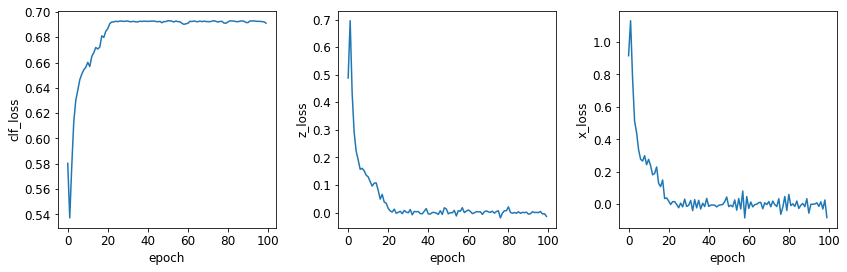

In [22]:
fig, ax = plot_history(eim_history)
plt.show()

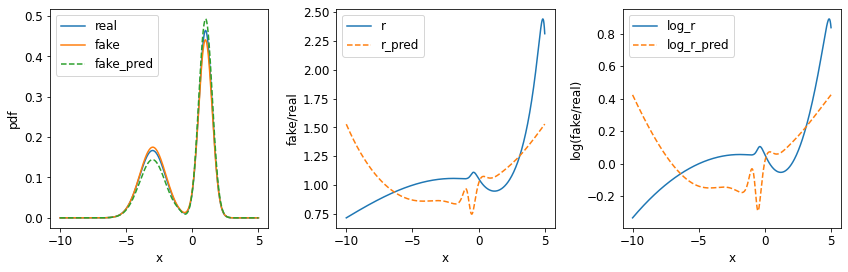

In [23]:
fig, ax = plot_diagnostics(real_gmm, q_gmm, clf)
plt.show()

Notes:
* While the fitted density passes the visual test again, it seems to slightly overestimate the density of the left component and underestimate the density of the right component. The estimated density ratio however is much closer to 1 for x < 0 than the previous methods.

## Method comparison

We will now put all three methods together and compare the quality of estimations. We measure the quality by the classifier's ability to distinguish the fake samples from the real samples. We can do this comparion by plotting the classifier loss history for all three methods over the epochs. All three methods achieved similar final classifier loss, meaning that they are equally good at generating realistic samples. 

Interestingly, stratified and gumbel-softmax sampling had similar learning curves. EIM was faster at achieving a high classifier loss. This is likely due to the iterative optimization of $\Pi$ and $Q_k(x)$ leading to tighter bound on the KL objective than pure sampling. 

Nevertheless, for this particular example, all three methods are good methods. However for bigger problems, we can consider the following tradeoffs:
1. If high accuracy is concerned, EIM might be the way to go
2. If high speed and low computational budget is concerned, gumbel-softmax might be preferred

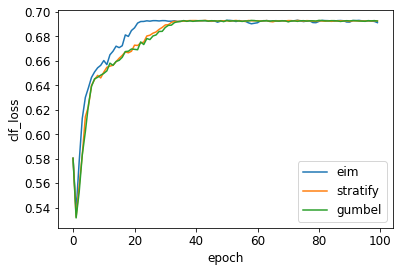

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(eim_history["clf_loss"], label="eim")
ax.plot(stratified_history["clf_loss"], label="stratify")
ax.plot(gumbel_history["clf_loss"], label="gumbel")
ax.set_xlabel("epoch")
ax.set_ylabel("clf_loss")
ax.legend()
plt.show()